In [1]:
import os
os.chdir('..')

In [2]:
from utils.dataset_loader import get_dataset
df = get_dataset(name='test.pkl')
df

['dataset.pkl', 'test.pkl', 'dataset.csv']


,Name,U,d,h,j,Isp,nu_t,T,m_a
0,SPT-20 [21],0.000000,0.000000,0.000000,0.166667,0.761194,0.006383,0.000000,0.000000
1,SPT-25 [22],0.062885,0.000000,0.071429,0.166667,0.104478,0.031915,0.020592,0.099001
2,HET-100 [23],0.093711,0.375000,0.121429,0.194444,0.238806,0.012766,0.037323,0.496821
3,KHT-40 [24],0.103730,0.453125,0.228571,0.388889,0.567164,0.053191,0.082368,0.617620
4,KHT-50 [24],0.108354,0.218750,0.385714,0.333333,0.552239,0.093617,0.099099,0.454133
...,...,...,...,...,...,...,...,...,...
995,NaN,0.308094,0.458892,0.350872,0.445752,0.364465,0.167806,0.274552,0.785498
996,NaN,0.137521,0.355245,0.654061,0.983175,0.648337,0.264442,0.267261,0.707738
997,NaN,0.233240,0.192072,-0.005484,0.110188,0.200909,-0.114530,0.095317,0.346141
998,NaN,0.098273,0.317621,0.604976,0.831365,0.639571,0.195979,0.145305,0.706969


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from livelossplot import PlotLosses

In [5]:
from torchmetrics import MeanAbsolutePercentageError

def train(X, model, loss_function, optim, num_epochs):
    loss_history = []
    
    liveloss = PlotLosses()

    for i,data in enumerate(X):
            
            epoch_loss = 0.0
            print(data[0])
            Y_pred = model(data[0])
            loss = loss_function(Y_pred, data[1])
            
            mean_abs_percentage_error = MeanAbsolutePercentageError()
            ape = mean_abs_percentage_error(Y_pred, data[1])
            
            loss.backward()
            optim.step()
            optim.zero_grad()
            
            print(ape)
            if (i+1)%20==0:
                liveloss.update({
                    'loss': loss.data.item(),
                    'APE' : 10 if ape.item()>10 else ape.item(),
                })
                liveloss.send()

In [315]:
from torch import nn, tensor
import torch
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.input = nn.Linear(2,8)
        self.act1 = nn.Tanh()
        self.layer2 = nn.Linear(8,16)
        # self.act2 = nn.LeakyReLU(negative_slope=0.3)
        self.layer3 = nn.Linear(16,32)
        # self.act3 = nn.Tanh()
        self.batchnorm = nn.BatchNorm1d(32)
        self.drop = nn.Dropout(p=0.05)
        self.layer4 = nn.Linear(32,16)
        # self.act4 = nn.LeakyReLU(negative_slope=0.3)
        self.layer5 = nn.Linear(16,8)
        # self.act5 = nn.ReLU()
        self.layer6 = nn.Linear(8,2)
        
    def forward(self, x):
        x = self.act1(self.input(x))
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.batchnorm(x)
        x = self.drop(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x
        
    
    

In [316]:
import torch
nonlinear_model = Net().float()

optim = torch.optim.AdamW(nonlinear_model.parameters(), lr=0.001)
loss_function = nn.L1Loss()

In [294]:
nonlinear_model(tensor([[1,2],[1,1]]).float())

tensor([[-0.4446,  0.0845],
        [-0.5124,  0.3849]], grad_fn=<AddmmBackward0>)

In [285]:
X = tensor(df.iloc[:,1:3].values[:800,:]).float()

Y = tensor(df.iloc[:,3:5].values[:800]).float()
print(X.shape, Y)
train_data = torch.utils.data.TensorDataset(X, Y)
Xtrain = torch.utils.data.DataLoader(train_data,batch_size=2)
# Ytrain = torch.utils.data.DataLoader(Y,batch_size=1)

torch.Size([800, 2]) tensor([[0.0000, 0.1667],
        [0.0714, 0.1667],
        [0.1214, 0.1944],
        ...,
        [0.6721, 0.7702],
        [0.7627, 0.8635],
        [0.5512, 0.7078]])


In [319]:
from torchviz import make_dot

make_dot(nonlinear_model(X), params=dict(list(nonlinear_model.named_parameters()))).render("ann", format="png")

'ann.png'

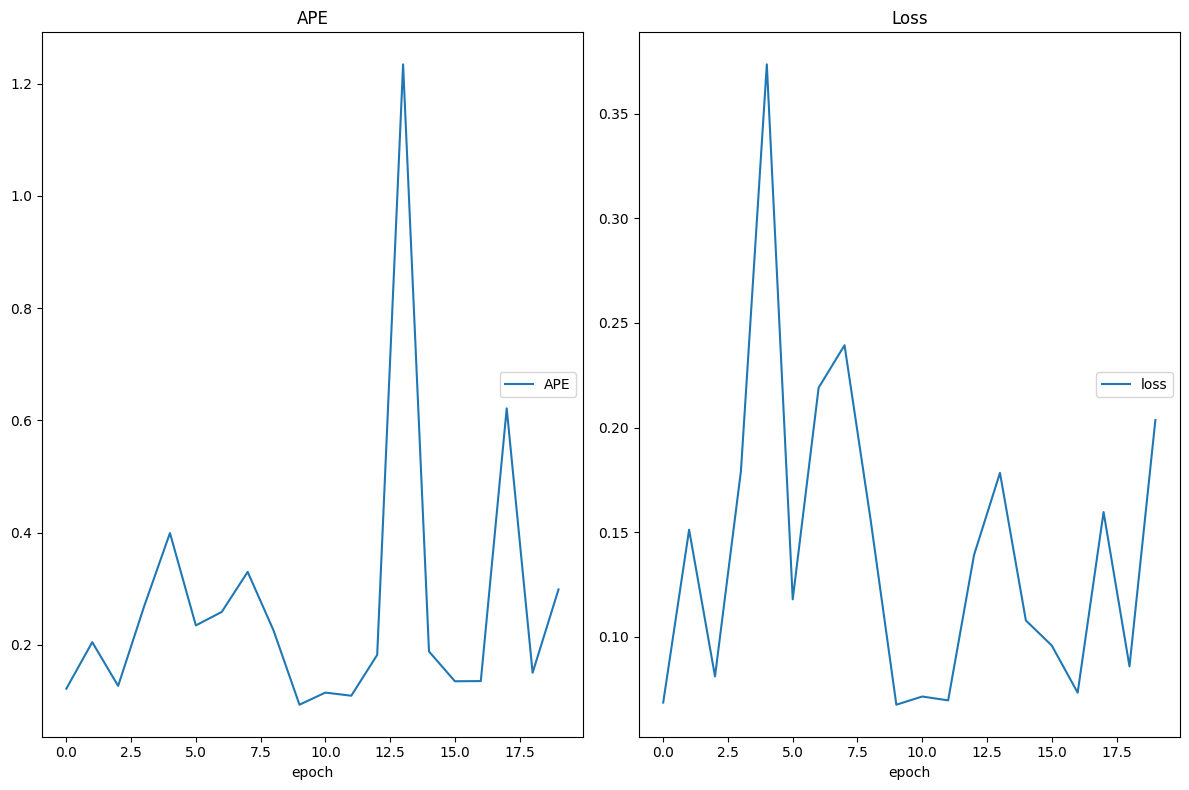

APE
	APE              	 (min:    0.093, max:    1.234, cur:    0.299)
Loss
	loss             	 (min:    0.067, max:    0.374, cur:    0.204)


In [317]:
nonlinear_model.train()
for j in range(10):
    train(Xtrain, nonlinear_model, loss_function, optim, num_epochs=200)

[[ 0.01992814  0.22081803]
 [-0.10801291  0.18514206]
 [ 0.4639335   0.5934081 ]
 ...
 [ 0.08991194  0.14197707]
 [-0.00392318  0.04705155]
 [-0.0510577   0.02005094]]


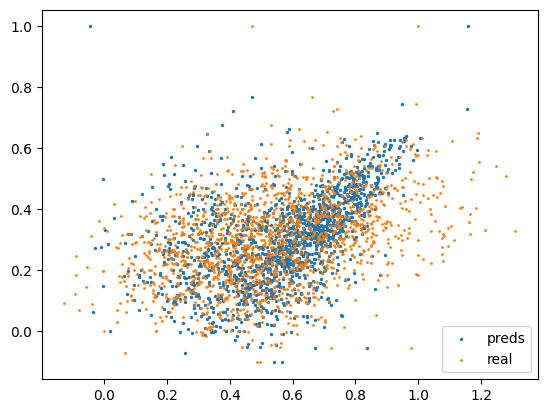

In [318]:

nonlinear_model.eval()
print((nonlinear_model(X).detach().numpy()-Y.numpy()))
plt.scatter(nonlinear_model(X).detach().numpy(),X,s=2,label='preds')
plt.scatter(Y,X,s=1,label='real')
plt.legend()

In [305]:
import numpy as np
print(round(100-abs(np.mean(nonlinear_model(X).detach().numpy()-Y.numpy())*100),2),'%')

95.78 %


In [320]:
input_names = ['P,D']
output_names = ['d,h']
torch.onnx.export(nonlinear_model, X, 'ann.onnx', input_names=input_names, output_names=output_names)